## 10-6. 프로젝트: 고양이 수염 스티커 만들기

### 스티커 구하기 or 만들기
<br/>    
**[고양이 수염 이미지]**    
https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1      
1. 고양이 수염 이미지 다운로드     
2. 셀카 이미지 촬영    

### step 2. 얼굴 검출 & 랜드마크 검출 하기
- dlib을 이용해서 얼굴의 bounding box 위치와 landmark 위치 찾기

---

## 0. Library Import

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

## 1. 사진 읽어오기 및 얼굴 인식

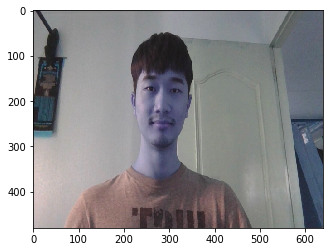

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/tae.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서

h,w,_ = img_bgr.shape
if h-w<0 :
    img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
else :
    img_bgr = cv2.resize(img_bgr, (480, 640))

img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()



In [3]:
'''
h,w,_ = img_bgr.shape
if h-w<0 :
    img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
else :
    img_bgr = cv2.resize(img_bgr, (480, 640))
    
=> 왜 이부분 이렇게 나눴는 지?
'''

'\nh,w,_ = img_bgr.shape\nif h-w<0 :\n    img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize\nelse :\n    img_bgr = cv2.resize(img_bgr, (480, 640))\n    \n=> 왜 이부분 이렇게 나눴는 지?\n'

In [4]:
# BRG => RGB 변경 및 얼굴 Detection

detector_hog = dlib.get_frontal_face_detector()   # detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of img pyramid)

rectangles[[(225, 153) (354, 282)]]


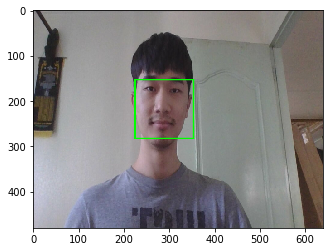

In [5]:
print(dlib_rects)    # 찾을 얼굴 영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

In [6]:
'''
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) 
이 코드는 왜 추가한 건지?
'''

'\nimg_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) \n이 코드는 왜 추가한 건지?\n'

## 2. 인식한 얼굴에서 랜드마크 추출
- 눈, 코, 입, 턱의 좌표를 추출

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


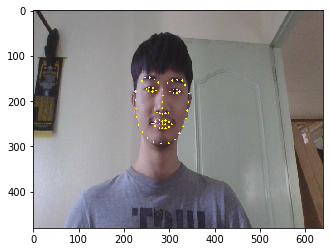

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. sticker 붙이기
### 3.1) Landmark 활용하여 sticker_area 구하기
- 수염을 붙이기 위해서 33번 점을 활용(코 끝)
- w, h => 얼굴 인식한 전체 사각형 (size = 155:155)

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[31][0]
    y = landmark[31][1] # - dlib_rect.width()//2
    
    # 얼굴을 인식한 사각형의 크기
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(285, 216)
(x,y) : (273,225)
(w,h) : (130,130)


In [11]:
'''
- dlib_rect.width() // 2 주석 처리한 이유는 ?
'''

'\n- dlib_rect.width() // 2 주석 처리한 이유는 ?\n'

### 3-2) 수염 이미지 가져오기
- 수염 이미지의 크기를 사각형의 크기와 동일하게 **resize** 해줌
- 수염 이미지를 뿌려줄 **촤측 상단**의 값 **(refined_x, refined_y)** 설정
    - y < 0 = 사진 영역 위로 나가는 영우
    - x < 0 = 사진 영역 왼쪽으로 나가는 경우      # 재호님 시잔 으로 오타 침

In [12]:

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))  # 얼굴을 detection한 bos의 사이즈로 resize
print (img_sticker.shape)

(130, 130, 3)


In [13]:
refined_x = x - img_sticker.shape[1] // 2  # left
refined_y = y - img_sticker.shape[0] // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)
    refined_y = 0
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (208,160)


In [14]:
'''
refined_x = x - img_sticker.shape[1] // 2  # left
refined_y = y - img_sticker.shape[0] // 2  # top

로 입력한 이유는? 

refined_x = x - h // 2  # left
refined_y = y #- w // 2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
이 아닌 이유는 ?

if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)
    refined_y = 0
    
'''

"\nrefined_x = x - img_sticker.shape[1] // 2  # left\nrefined_y = y - img_sticker.shape[0] // 2  # top\n\n로 입력한 이유는? \n\nrefined_x = x - h // 2  # left\nrefined_y = y #- w // 2       # top\nprint ('(x,y) : (%d,%d)'%(refined_x, refined_y))\n이 아닌 이유는 ?\n\nif refined_y < 0 :\n    img_sticker = img_sticker[-refined_y:]\n    print (img_sticker.shape)\n    refined_y = 0\n    \n"

### 3-3) sticker_area 영역 확인
- x값 범위: 좌측(reined_x)점 부터 스티커의 길이만큼 더한 범위
- y값 범위: 

In [15]:
'''어떻게 이 범위를 설정했는지?'''

'어떻게 이 범위를 설정했는지?'

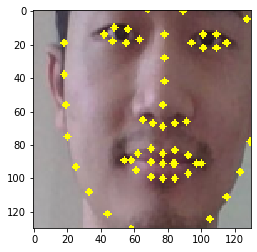

In [16]:
plt.imshow(img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]])

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

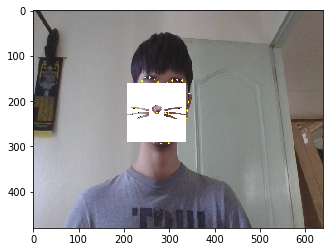

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

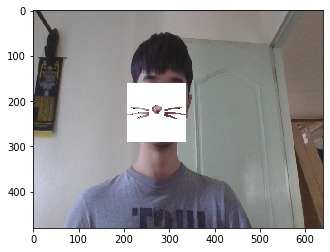

In [19]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()